In [1]:
import json
import pandas as pd
import re
import random
import numpy as np
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

######## METRICS

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# matplotlib

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]

    return reviews

In [15]:
def classify_it(filename, parametr): 
    i = 0
    reviews_lst_good= []
    reviews_lst_bad = []

    #набираем список хороших/плохих отзывов, не более 500000 в каждом из списков
    
    with open(filename, 'r') as f:
            for line in f:
                if json.loads(line)['overall'] > 3 and len(reviews_lst_good)<=500000:
                    reviews_lst_good.append (json.loads(line))

                elif json.loads(line)['overall'] < 3 and len(reviews_lst_bad)<=500000:
                    reviews_lst_bad.append (json.loads(line))

                if len(reviews_lst_good) + len (reviews_lst_bad) == 1000000:
                    break
    # random elements in the list
    
    # перемешиваем список
    
    random.shuffle(reviews_lst_good)
    random.shuffle(reviews_lst_bad)  
    
    # создаём template для сохранения конечных отзывов
    reviewerID_lst = []
    reviewerName_lst = []
    reviewText_lst = []
    overall_lst = []
    summary_lst = []
    
    # где будем уменьшать количество отзывов, дабы их было равное количество
    
    if len (reviews_lst_bad) < len(reviews_lst_good):
        count_otz = len (reviews_lst_bad)
    else:
        count_otz = len (reviews_lst_good)

    # обрезаем хороший
    for i in reviews_lst_good[:count_otz]:
        reviewText_lst.append (i['reviewText'])
        overall_lst.append (i['overall'])

    print ('Good: ',len(reviews_lst_good[:count_otz]))

    # обрезаем плохие
    for i in reviews_lst_bad[:count_otz]:
        reviewText_lst.append (i['reviewText'])
        overall_lst.append (i['overall'])
        
    print ('Bad: ',len(reviews_lst_bad[:count_otz]))
    
#     test_len = int(round (len(reviews_lst_bad[:count_otz])*0.1,0))
#     #длина выборки, на которой строим тесты  
#     print ('10%: ',test_len)

    df = pd.DataFrame ()

    
    df['reviewText'] = reviewText_lst
    df['overall'] = overall_lst
    
    # 0 и 1 ставим
    df ['mark'] = 0
    df.loc[df['overall'] > 3,'mark'] = 1
    
    # количество отзывов в нормальной и тестовой выборке
    reviews_train = list(df[df['overall'] > 3]['reviewText']) + list(df[df['overall'] < 3]['reviewText'])

    # очищаем отзывы от всяких лишних символов
    reviews_train_clean = preprocess_reviews(reviews_train)
    
    # бинаризируем столбец признаков
    cv = TfidfVectorizer(binary=True)
    cv.fit(reviews_train_clean)
    
    # к норм виду приводим
    X = cv.transform(reviews_train_clean)

    
    # столбец ответов 
    y = list(df[df['overall'] > 3]['mark']) + list(df[df['overall'] < 3]['mark'])
    
    
    # делим выборку на тестовую и обучающую
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, train_size = 0.75
    )
    
    
    print ('Подбор параметра для: ', filename[:-5])
    print ('    ')
    
    
    best_c_dict = {}
    main_dict = {}
    c_list = []
    result_1_list = []
    result_2_list = []
    
    # определяем, где алгоритму необходимо искать С
    grid = np.power(10.0, np.arange(-4, 4))
    
    # итерируемся и подбираем параметр, используя Accuracy
    for c in grid:
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        print ("Accuracy for C=%s: %s" 
               % (c, accuracy_score(y_val, lr.predict(X_val))))
        
        c_list.append (c)
        result_1_list.append (accuracy_score(y_val, lr.predict(X_val)))

        best_c_dict [c] = accuracy_score(y_val, lr.predict(X_val))
        main_dict [c] = [filename, accuracy_score(y_val, lr.predict(X_val))]
        
    
    # записываем результаты
    result = pd.DataFrame()
    result['c'] = c_list
    result ['result_1'] = result_1_list
    result.to_csv (filename[:-5]+'_podbor_c.csv', index=False)
    ###############
    
    inverse = [(value, key) for key, value in best_c_dict.items()]
    print ('The best C is ', max(inverse)[1])

    # находим лучший результат и записываем его + используем для модели
    
    final_model = LogisticRegression(C=max(inverse)[1])
    print ('So model use C = ', max(inverse)[1])
    final_model.fit(X_train,  y_train)
    print ("Final Accuracy: %s" 
           % accuracy_score(y_val
                            , final_model.predict(X_val)))
    
    print('confusion_matrix')
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_val, final_model.predict(X_val))
    print(confusion_matrix)
    
    print ('classification_report')
    print(classification_report(y_val, final_model.predict(X_val)))
    
    
    print ('roc crivai')
    

    logit_roc_auc = roc_auc_score(y_val, final_model.predict(X_val))
    fpr, tpr, thresholds = roc_curve(y_val, final_model.predict_proba(X_val)[:,1])
    plt.figure()
    
    
    data = {'fpr': fpr, 'tpr': tpr}
    df = pd.DataFrame.from_dict(data)
    df.to_csv (filename[:-5]+'_roc_crivai.csv', index=False)
    
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
    # выделяем слова, которые обладают самым большим весом
    feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
        )
    }
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:25]:
        print (best_positive)
    

#     word_lst = []
#     score_lst = []
#     for i in best_positive:
#         word_lst.append (i)
#         score_lst.append (best_positive[i])
    
#     data = {'word': word_ls, 'level': score_lst}
#     df = pd.DataFrame.from_dict(data)
#     df.to_csv (filename[:-5]+'_posit_words.csv', index=False)
    
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:25]:
        print (best_negative)
    
#     word_lst = []
#     score_lst = []
#     for i in best_negative:
#         word_lst.append (i)
#         score_lst.append (best_negative[i])
    
#     data = {'word': word_ls, 'level': score_lst}
#     df = pd.DataFrame.from_dict(data)
#     df.to_csv (filename[:-5]+'_negat_words.csv', index=False)
        
    del reviews_lst_good
    del reviews_lst_bad
    
    return main_dict

Health_and_Personal_Care_5
   
Good:  33300
Bad:  33300
Подбор параметра для:  /Volumes/GoogleDrive/Мой диск/Work/Experiment/Health_and_Personal_Care_5
    
Accuracy for C=0.0001: 0.8033033033033034
Accuracy for C=0.001: 0.8058258258258258
Accuracy for C=0.01: 0.8156756756756757
Accuracy for C=0.1: 0.8393393393393394
Accuracy for C=1.0: 0.8578978978978979
Accuracy for C=10.0: 0.856936936936937
Accuracy for C=100.0: 0.8372972972972973
Accuracy for C=1000.0: 0.8112312312312312
The best C is  1.0
So model use C =  1.0
Final Accuracy: 0.8578978978978979
confusion_matrix
[[7182 1157]
 [1209 7102]]
classification_report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      8339
           1       0.86      0.85      0.86      8311

   micro avg       0.86      0.86      0.86     16650
   macro avg       0.86      0.86      0.86     16650
weighted avg       0.86      0.86      0.86     16650

roc crivai


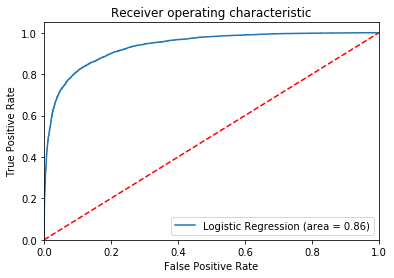

('great', 9.455904939800822)
('easy', 7.747339964632249)
('love', 7.416509039155611)
('perfect', 6.482918886131326)
('highly', 6.459785041328802)
('best', 5.662015402728544)
('helps', 5.531222629248048)
('works', 5.447605160917793)
('good', 5.3690493790216625)
('pleased', 5.234365144612823)
('glad', 5.005156635290512)
('excellent', 4.97632351896072)
('amazing', 4.6709310111760045)
('price', 4.560658694335446)
('well', 4.5361999916480755)
('happy', 4.373457640512627)
('nice', 4.202275380158621)
('awesome', 4.135633449384833)
('definitely', 3.994635781411979)
('stores', 3.90961432275062)
('helped', 3.859530194998807)
('complaints', 3.7506716000076548)
('wonderful', 3.6129374658702713)
('little', 3.538022643528788)
('job', 3.4746125077258956)
('not', -12.101536521569306)
('didnt', -7.037247924851184)
('unfortunately', -6.797312316542903)
('waste', -6.544465579856055)
('disappointed', -6.2142846350808805)
('nothing', -5.695998116998799)
('return', -5.440489868058382)
('money', -5.203112124

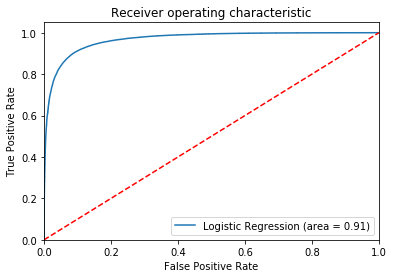

('great', 11.467916307029263)
('excellent', 9.37108013671421)
('perfect', 8.505895351545213)
('superb', 7.653092338699948)
('best', 7.636206766762143)
('classic', 7.620213151858342)
('wonderful', 7.597201760783486)
('love', 6.911074001037734)
('fun', 6.863222704800594)
('favorite', 6.849145247784895)
('complaint', 6.7273597034414845)
('enjoyed', 6.599862330078621)
('hilarious', 6.409437616253612)
('highly', 6.386344655834226)
('awesome', 6.31426355420321)
('gem', 6.081297426964912)
('still', 6.0160737520165855)
('amazing', 5.9390678260796435)
('loved', 5.908192337998348)
('fantastic', 5.8151818917869935)
('brilliant', 5.721670038439354)
('perfectly', 5.577550475572951)
('outstanding', 5.514075821637329)
('well', 5.270008349155613)
('today', 5.166033692648291)
('worst', -14.480746891149264)
('waste', -13.60015073069434)
('boring', -12.772352359403868)
('not', -10.628364275694274)
('terrible', -9.896499766343258)
('awful', -9.875902837537648)
('poorly', -9.74523648667559)
('wasted', -9.1

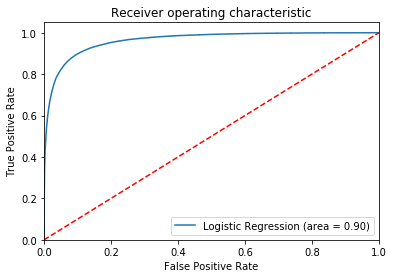

('great', 12.652939399953055)
('excellent', 9.658157077365024)
('perfect', 9.208188293061603)
('highly', 8.702910013055257)
('pleased', 7.977833815676673)
('love', 7.861364779329364)
('perfectly', 7.768427385515809)
('beat', 7.534062265064675)
('easy', 7.524506498585463)
('amazing', 7.481305596368506)
('best', 7.181756076944142)
('happy', 7.05424570897923)
('works', 6.918832174652268)
('complaint', 6.650966990401179)
('price', 6.176695031029661)
('satisfied', 6.138236373423557)
('glad', 6.097710724340095)
('complaints', 6.090410996889075)
('flawlessly', 6.03208884915192)
('awesome', 5.949468172714269)
('fantastic', 5.92115474756272)
('well', 5.842960911186257)
('solid', 5.71909045753898)
('good', 5.687704377601205)
('worry', 5.458292511415676)
('not', -13.832769387950037)
('returned', -12.574064458761583)
('returning', -11.99416462480859)
('return', -11.983374284438693)
('poor', -10.569370289938616)
('useless', -9.81758100345318)
('disappointing', -9.226836252025434)
('worst', -9.11240

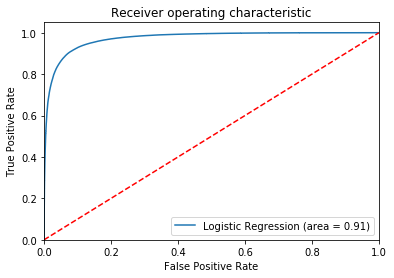

('klausner', 22.894886687640632)
('pleasantly', 11.904375409726708)
('refreshing', 11.72073036373694)
('spong', 11.250251174596114)
('ariely', 11.135500363849694)
('ehrman', 10.997275894175656)
('aria', 10.777927604639247)
('great', 10.645977703933001)
('excellent', 10.40675242124196)
('everneath', 10.045587058582155)
('olaf', 9.986031866749924)
('gaiman', 9.695111230751209)
('enjoyed', 9.653948863817998)
('complaint', 9.62395711030103)
('loved', 9.167199848369895)
('quibble', 9.033880179294492)
('disappoint', 8.844496263713477)
('delightful', 8.831009267140423)
('rollins', 8.765421476831106)
('refreshingly', 8.762099883465625)
('invaluable', 8.753768588733422)
('maxon', 8.736424956767552)
('fascinating', 8.655812112472196)
('harpercollins', 8.650966876478865)
('fayz', 8.626011762498072)
('waste', -15.375592287105839)
('disappointing', -15.128260622520532)
('not', -14.793160931170714)
('poorly', -14.664286969167753)
('booksneeze', -14.083892050598404)
('boring', -13.484073345967538)
('

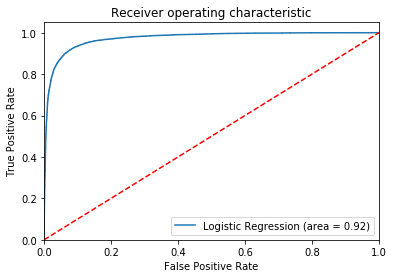

('loved', 10.654180577268429)
('enjoyed', 10.13683331509561)
('great', 9.731122899758251)
('wait', 8.09967501494773)
('highly', 6.877205665925286)
('love', 6.70572117834582)
('fun', 6.667536102492365)
('wonderful', 6.591694762648545)
('excellent', 6.057781580805142)
('well', 6.019660443882345)
('good', 5.669314096023509)
('amazing', 5.54933412808288)
('enjoyable', 5.471001838754129)
('disappoint', 5.271263170862459)
('awesome', 5.205687700000074)
('heart', 5.122502513293404)
('liked', 5.110171248234603)
('hooked', 5.032214159342136)
('easy', 4.673454561711911)
('job', 4.6222032733991165)
('perfect', 4.6003434631268565)
('definitely', 4.545751274549072)
('forward', 4.545361986487754)
('you', 4.536649108082936)
('hot', 4.461072037943667)
('not', -12.758806460991584)
('waste', -8.406144284749866)
('boring', -7.4032397286308)
('didnt', -6.972393515360903)
('no', -6.953855238256303)
('disappointing', -6.41202265212373)
('unfortunately', -6.384635062019179)
('nothing', -6.381653469433233)
('

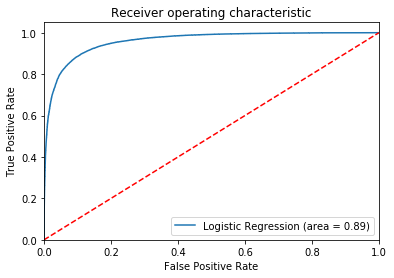

('great', 10.467789535017626)
('best', 8.964048277934898)
('favorite', 8.500508267947872)
('excellent', 7.626864894035869)
('favorites', 7.196245606003844)
('perfect', 7.135009469926713)
('amazing', 6.652192493602604)
('classic', 6.383409515672791)
('awesome', 6.226738026595528)
('wonderful', 6.106868250944673)
('beautiful', 5.547677207348725)
('love', 5.2310116092468855)
('still', 5.2233765438075626)
('finest', 5.166916446761679)
('you', 5.144840810812476)
('fantastic', 5.0941489531795785)
('solid', 4.922383054885458)
('quot', 4.921181663691687)
('also', 4.864274924775691)
('highly', 4.845857641728825)
('brilliant', 4.843078392369178)
('incredible', 4.841993832968819)
('must', 4.7916193640133296)
('rocks', 4.744485305331329)
('today', 4.734741765432199)
('worst', -13.509865964023058)
('boring', -11.455906898704036)
('awful', -9.132105444987777)
('disappointing', -8.702327169180348)
('horrible', -8.46056875025797)
('disappointment', -8.39273144372059)
('worse', -8.380813772631319)
('te

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [17]:
import os
import gc

os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment')

for i in os.listdir('/Volumes/GoogleDrive/Мой диск/Work/Experiment'):
    if i[-5:] != 'ipynb'and i[-3:] != 'csv' and i != '.ipynb_checkpoints': # and i == 'Health_and_Personal_Care_5.json':
        print (i[:-5])
        print ('   ')
        dict_main = classify_it ('/Volumes/GoogleDrive/Мой диск/Work/Experiment/' + i, 0.25)
        gc.collect()
        

In [ ]:
# import numpy as np
# import matplotlib.mlab as mlab
# import matplotlib.pyplot as plt
# %matplotlib inline

# x_lst = []
# y_lst = []
# for i in dict_main:
#     x_lst.append(i)
#     y_lst.append(dict_main[i][1])

# plt.bar(x_lst, y_lst, align='center', alpha=0.3, width=0.1)

In [ ]:
result = pd.DataFrame( = [1,2,3], b = [4,5,6])
result

Comments

https://habr.com/ru/company/ods/blog/323890/#1-lineynaya-regressiya

https://docplayer.ru/28834116-Otchet-po-zadaniyu-4-issledovanie-modeli-logistic-regression.html

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_(%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9,_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2)#.D0.9E.D1.81.D0.BD.D0.BE.D0.B2.D0.BD.D1.8B.D0.B5_.D0.BF.D0.BE.D0.BD.D1.8F.D1.82.D0.B8.D1.8F_.D0.B8_.D0.BF.D1.80.D0.B8.D0.BC.D0.B5.D1.80.D1.8B_.D0.BF.D1.80.D0.B8.D0.BA.D0.BB.D0.B0.D0.B4.D0.BD.D1.8B.D1.85_.D0.B7.D0.B0.D0.B4.D0.B0.D1.87



ROC:
https://basegroup.ru/community/articles/logistic

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8